In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
from scipy.stats import beta as sp_beta

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = 20, 15
plt.rcParams['font.size'] = 20
plt.rcParams['lines.linewidth'] = 2
import seaborn as sns

import sys
sys.path.insert(0, '../../..')
import assignment
import leximin_assignment
import matrix_gen
import kde_utils

from tqdm import tqdm

import warnings

In [2]:
pof_df = pd.read_csv('pof_df.csv')

print(pof_df.shape)
pof_df.head()

(500, 16)


,"uniform(0, 1)","uniform(0, 1)_sorted","beta(1, 6)","beta(1, 6)_sorted","beta(6, 1)","beta(6, 1)_sorted","beta(2, 5)","beta(2, 5)_sorted","beta(5, 2)","beta(5, 2)_sorted","beta(0.5, 0.5)","beta(0.5, 0.5)_sorted","beta(0.6, 0.1)","beta(0.6, 0.1)_sorted","beta(0.1, 0.6)","beta(0.1, 0.6)_sorted"
0,1.008206,1.044019,1.005459,1.046464,1.000000,1.018569,1.03055,1.027236,1.000000,1.028134,1.017451,1.059270,1.000000,1.025862,1.000000,1.000000
1,1.014315,1.083174,1.002986,1.071895,1.002592,1.022789,1.00000,1.043394,1.001829,1.046792,1.000000,1.035171,1.004635,1.023892,1.000000,1.000000
2,1.001647,1.015748,1.000229,1.011592,1.000806,1.012952,1.00000,1.029004,1.000000,1.008398,1.000000,1.052994,1.012260,1.025020,1.000000,1.000000
3,1.005338,1.029156,1.005972,1.008441,1.000000,1.017438,1.00000,1.021022,1.000000,1.008951,1.000000,1.043385,1.000000,1.030679,1.000000,1.000000
4,1.025598,1.036391,1.013452,1.028359,1.000000,1.019482,1.00000,1.032147,1.000000,1.016615,1.000000,1.035351,1.000000,1.016476,1.001645,1.038469


In [6]:
pof_df.stack().reset_index().drop(columns=['level_0'])

,level_1,0
0,"uniform(0, 1)",1.008206
1,"uniform(0, 1)_sorted",1.044019
2,"beta(1, 6)",1.005459
3,"beta(1, 6)_sorted",1.046464
4,"beta(6, 1)",1.000000
...,...,...
7995,"beta(0.5, 0.5)_sorted",1.042679
7996,"beta(0.6, 0.1)",1.002229
7997,"beta(0.6, 0.1)_sorted",1.024826
7998,"beta(0.1, 0.6)",1.000000


In [10]:
stacked_df = pof_df.stack().reset_index().drop(columns=['level_0']).rename(columns={0: 'PoF'})
stacked_df

,level_1,PoF
0,"uniform(0, 1)",1.008206
1,"uniform(0, 1)_sorted",1.044019
2,"beta(1, 6)",1.005459
3,"beta(1, 6)_sorted",1.046464
4,"beta(6, 1)",1.000000
...,...,...
7995,"beta(0.5, 0.5)_sorted",1.042679
7996,"beta(0.6, 0.1)",1.002229
7997,"beta(0.6, 0.1)_sorted",1.024826
7998,"beta(0.1, 0.6)",1.000000


In [15]:
list(pof_df.columns)

['uniform(0, 1)',
 'uniform(0, 1)_sorted',
 'beta(1, 6)',
 'beta(1, 6)_sorted',
 'beta(6, 1)',
 'beta(6, 1)_sorted',
 'beta(2, 5)',
 'beta(2, 5)_sorted',
 'beta(5, 2)',
 'beta(5, 2)_sorted',
 'beta(0.5, 0.5)',
 'beta(0.5, 0.5)_sorted',
 'beta(0.6, 0.1)',
 'beta(0.6, 0.1)_sorted',
 'beta(0.1, 0.6)',
 'beta(0.1, 0.6)_sorted']

In [16]:
for i in range(8):
    print(pof_df.columns[i * 2])

uniform(0, 1)
beta(1, 6)
beta(6, 1)
beta(2, 5)
beta(5, 2)
beta(0.5, 0.5)
beta(0.6, 0.1)
beta(0.1, 0.6)


In [18]:
# stacked_df['Distribution'] = list(pof_df.columns) * 500

distributions = []
for i in range(8):
    distributions += [pof_df.columns[i * 2]] * 2
stacked_df['Distribution'] = distributions * 500

stacked_df

,level_1,PoF,Distribution
0,"uniform(0, 1)",1.008206,"uniform(0, 1)"
1,"uniform(0, 1)_sorted",1.044019,"uniform(0, 1)"
2,"beta(1, 6)",1.005459,"beta(1, 6)"
3,"beta(1, 6)_sorted",1.046464,"beta(1, 6)"
4,"beta(6, 1)",1.000000,"beta(6, 1)"
...,...,...,...
7995,"beta(0.5, 0.5)_sorted",1.042679,"beta(0.5, 0.5)"
7996,"beta(0.6, 0.1)",1.002229,"beta(0.6, 0.1)"
7997,"beta(0.6, 0.1)_sorted",1.024826,"beta(0.6, 0.1)"
7998,"beta(0.1, 0.6)",1.000000,"beta(0.1, 0.6)"


In [19]:
stacked_df['Sorted'] = [False, True] * 4000
stacked_df

,level_1,PoF,Distribution,Sorted
0,"uniform(0, 1)",1.008206,"uniform(0, 1)",False
1,"uniform(0, 1)_sorted",1.044019,"uniform(0, 1)",True
2,"beta(1, 6)",1.005459,"beta(1, 6)",False
3,"beta(1, 6)_sorted",1.046464,"beta(1, 6)",True
4,"beta(6, 1)",1.000000,"beta(6, 1)",False
...,...,...,...,...
7995,"beta(0.5, 0.5)_sorted",1.042679,"beta(0.5, 0.5)",True
7996,"beta(0.6, 0.1)",1.002229,"beta(0.6, 0.1)",False
7997,"beta(0.6, 0.1)_sorted",1.024826,"beta(0.6, 0.1)",True
7998,"beta(0.1, 0.6)",1.000000,"beta(0.1, 0.6)",False


In [20]:
stacked_df = stacked_df.drop(columns=['level_1'])
stacked_df

,PoF,Distribution,Sorted
0,1.008206,"uniform(0, 1)",False
1,1.044019,"uniform(0, 1)",True
2,1.005459,"beta(1, 6)",False
3,1.046464,"beta(1, 6)",True
4,1.000000,"beta(6, 1)",False
...,...,...,...
7995,1.042679,"beta(0.5, 0.5)",True
7996,1.002229,"beta(0.6, 0.1)",False
7997,1.024826,"beta(0.6, 0.1)",True
7998,1.000000,"beta(0.1, 0.6)",False


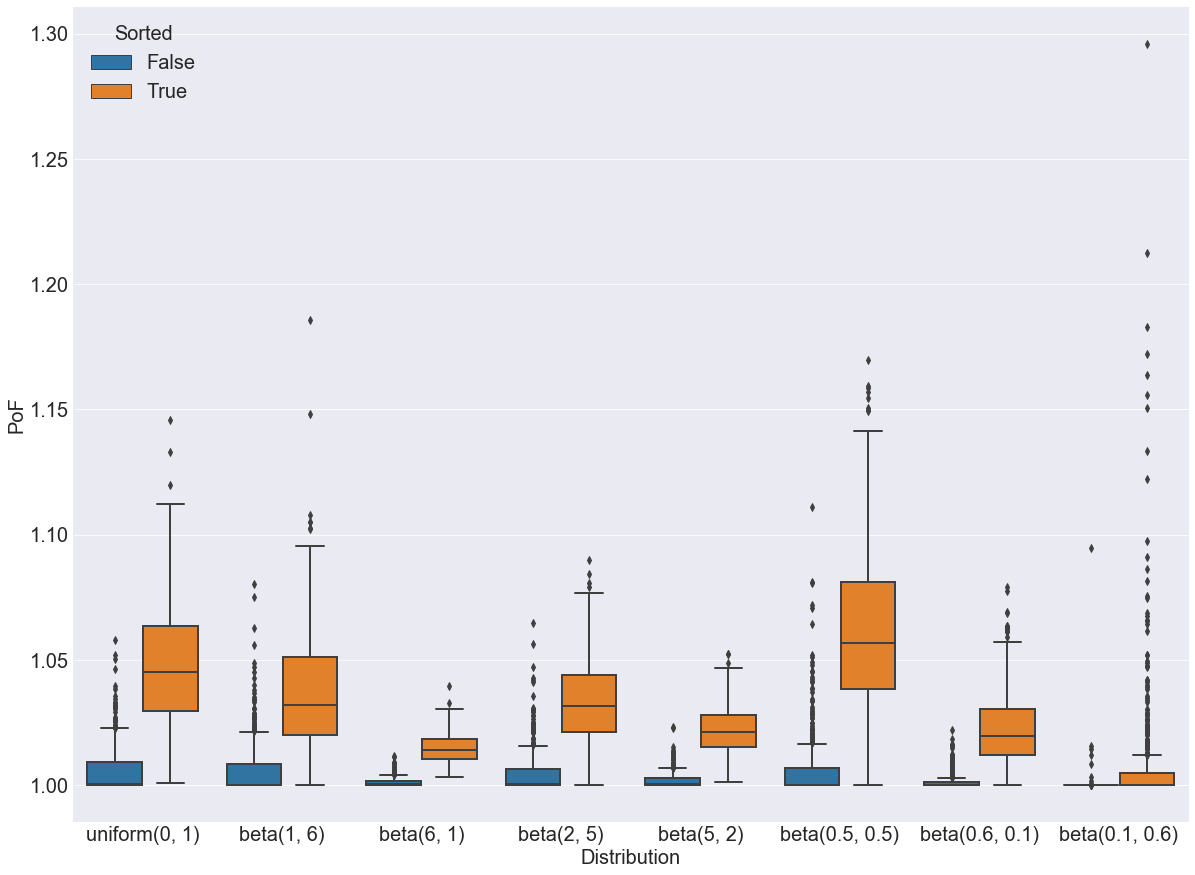

In [22]:
sns.boxplot(x='Distribution', y='PoF', hue='Sorted', data=stacked_df)
plt.show()

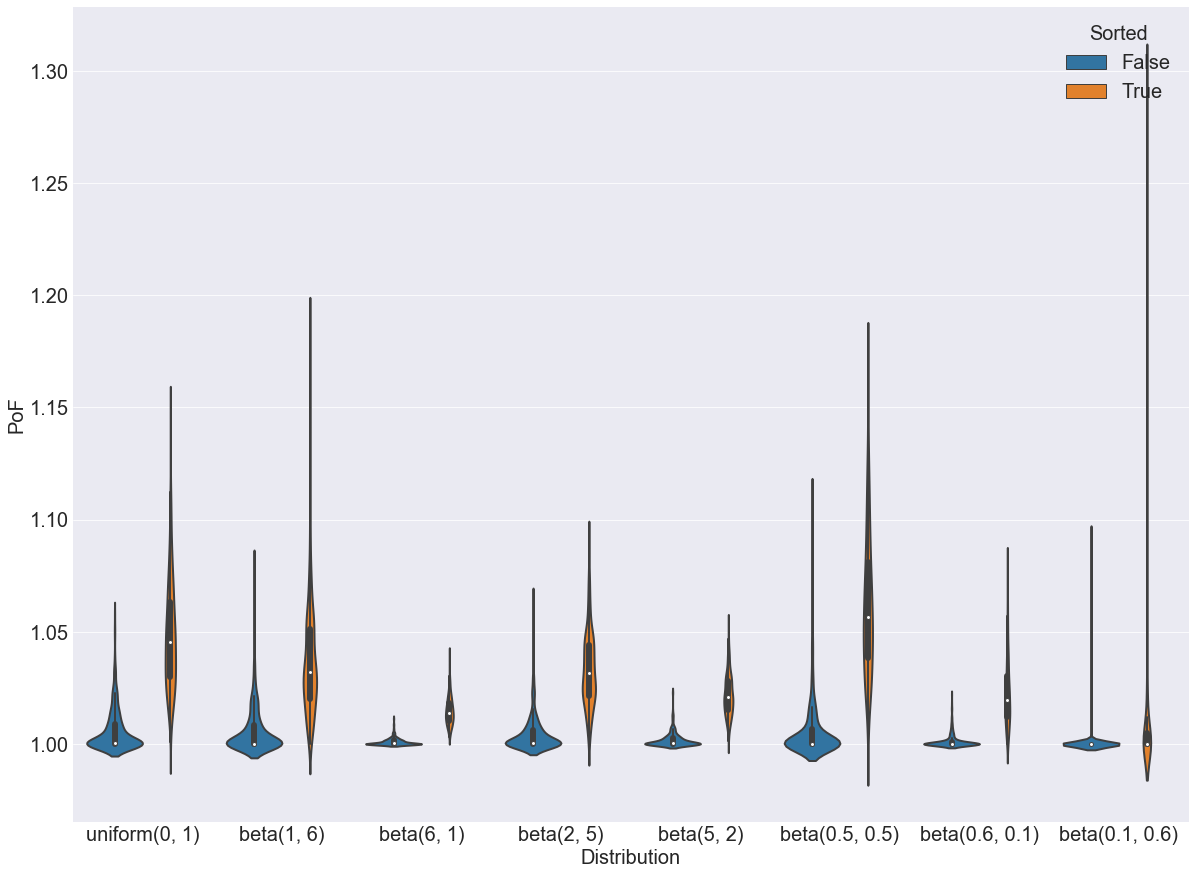

In [24]:
sns.violinplot(x='Distribution', y='PoF', hue='Sorted', data=stacked_df)
plt.show()

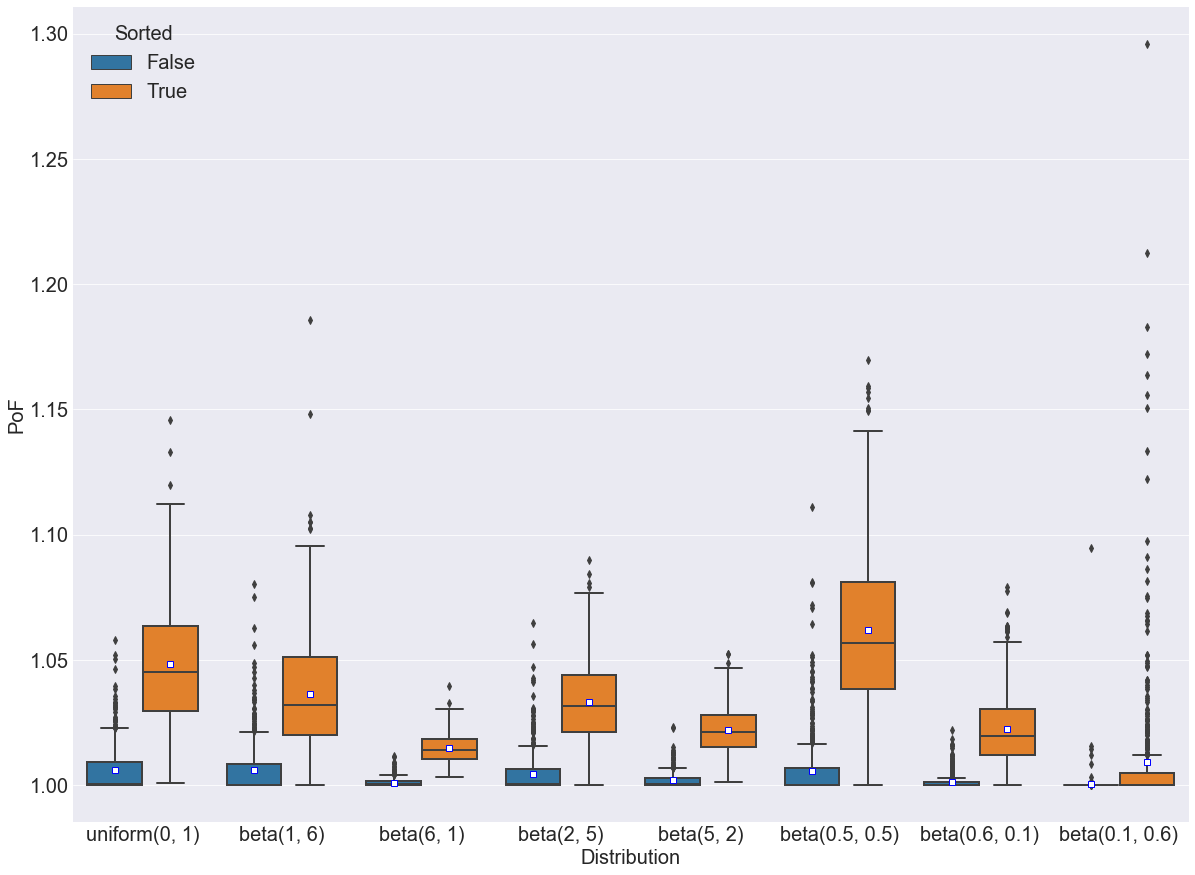

In [26]:
sns.boxplot(
    x='Distribution', y='PoF', hue='Sorted', data=stacked_df,
    showmeans=True, meanprops={"marker": "s","markerfacecolor": "white", "markeredgecolor": "blue"}
)
plt.show()

# New data set

In [3]:
pof_df = pd.read_csv('pof.csv')
pof_df

,PoF,Source,Sorted
0,1.008206,"uniform(0, 1)",False
1,1.044019,"uniform(0, 1)",True
2,1.005459,"beta(1, 6)",False
3,1.046464,"beta(1, 6)",True
4,1.000000,"beta(6, 1)",False
...,...,...,...
8995,1.008018,"beta(0.6, 0.1)",True
8996,1.000000,"beta(0.1, 0.6)",False
8997,1.000000,"beta(0.1, 0.6)",True
8998,1.005356,KDE,False


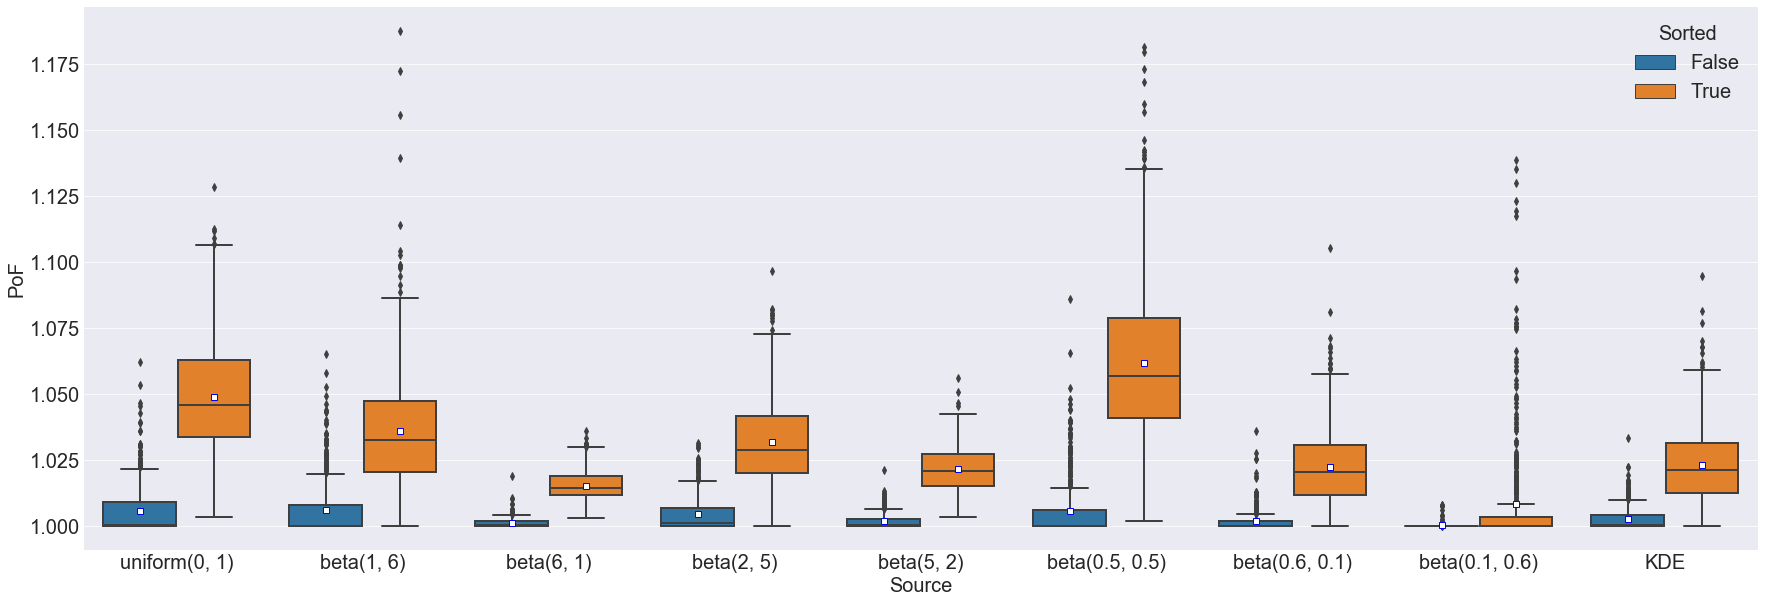

In [10]:
plt.figure(figsize=(30, 10))

sns.boxplot(
    x='Source', y='PoF', hue='Sorted', data=pof_df,
    showmeans=True, meanprops={"marker": "s","markerfacecolor": "white", "markeredgecolor": "blue"}
)
plt.show()

# Distributions of normalized costs

In [11]:
df = pd.read_csv('../../../data/data.csv', index_col=0)
types = ['ES', 'TH', 'RRH', 'PREV']
df = df[df['Real'] != 2]
df = df.drop(labels='PSH', axis=1)

data = df[types].to_numpy().flatten()
kde = kde_utils.KDEHelper(np.log(data) - np.log(1 - data))

In [23]:
N = 30
N_INTVS = 5
N_EXPERIMENTS = 1000  # 10 and 500

CAPACITIES = np.ones((N_INTVS,), dtype=int) * (N // N_INTVS)

In [24]:
distributions = [
    np.random.uniform,
    np.random.beta,
    np.random.beta,
    np.random.beta,
    np.random.beta,
    np.random.beta,
    np.random.beta,
    np.random.beta,
    kde.sample_and_transform
]

dist_params = [
    (0, 1),
    (1, 6),
    (6, 1),
    (2, 5),
    (5, 2),
    (0.5, 0.5),
    (0.6, 0.1),
    (0.1, 0.6),
    (lambda x: 1 / (1 + np.exp(-x)), None)
]

matrix_generators = [
    matrix_gen.MatrixGenerator(dist, params, N, N_INTVS)
    for dist, params in zip(distributions, dist_params)
]

labels = [
    f'{dist.__name__}({params[0]}, {params[1]})'
    for dist, params in zip(distributions, dist_params)
]
labels[-1] = 'KDE'

labels

['uniform(0, 1)',
 'beta(1, 6)',
 'beta(6, 1)',
 'beta(2, 5)',
 'beta(5, 2)',
 'beta(0.5, 0.5)',
 'beta(0.6, 0.1)',
 'beta(0.1, 0.6)',
 'KDE']

In [25]:
cost_pop = [np.array([]) for _ in range(len(labels))]
increase_pop = [np.array([]) for _ in range(len(labels))]

for _ in tqdm(range(N_EXPERIMENTS)):
    for dist_id in range(len(labels)):
        (matrix, _), (increase_matrix, __) = matrix_generators[dist_id].get_increase_matrix_pair()
        
        cost_pop[dist_id] = np.concatenate([
            cost_pop[dist_id],
            matrix.flatten()
        ])
        
        increase_pop[dist_id] = np.concatenate([
            increase_pop[dist_id],
            increase_matrix.flatten()
        ])

100%|██████████| 1000/1000 [00:03<00:00, 324.22it/s]


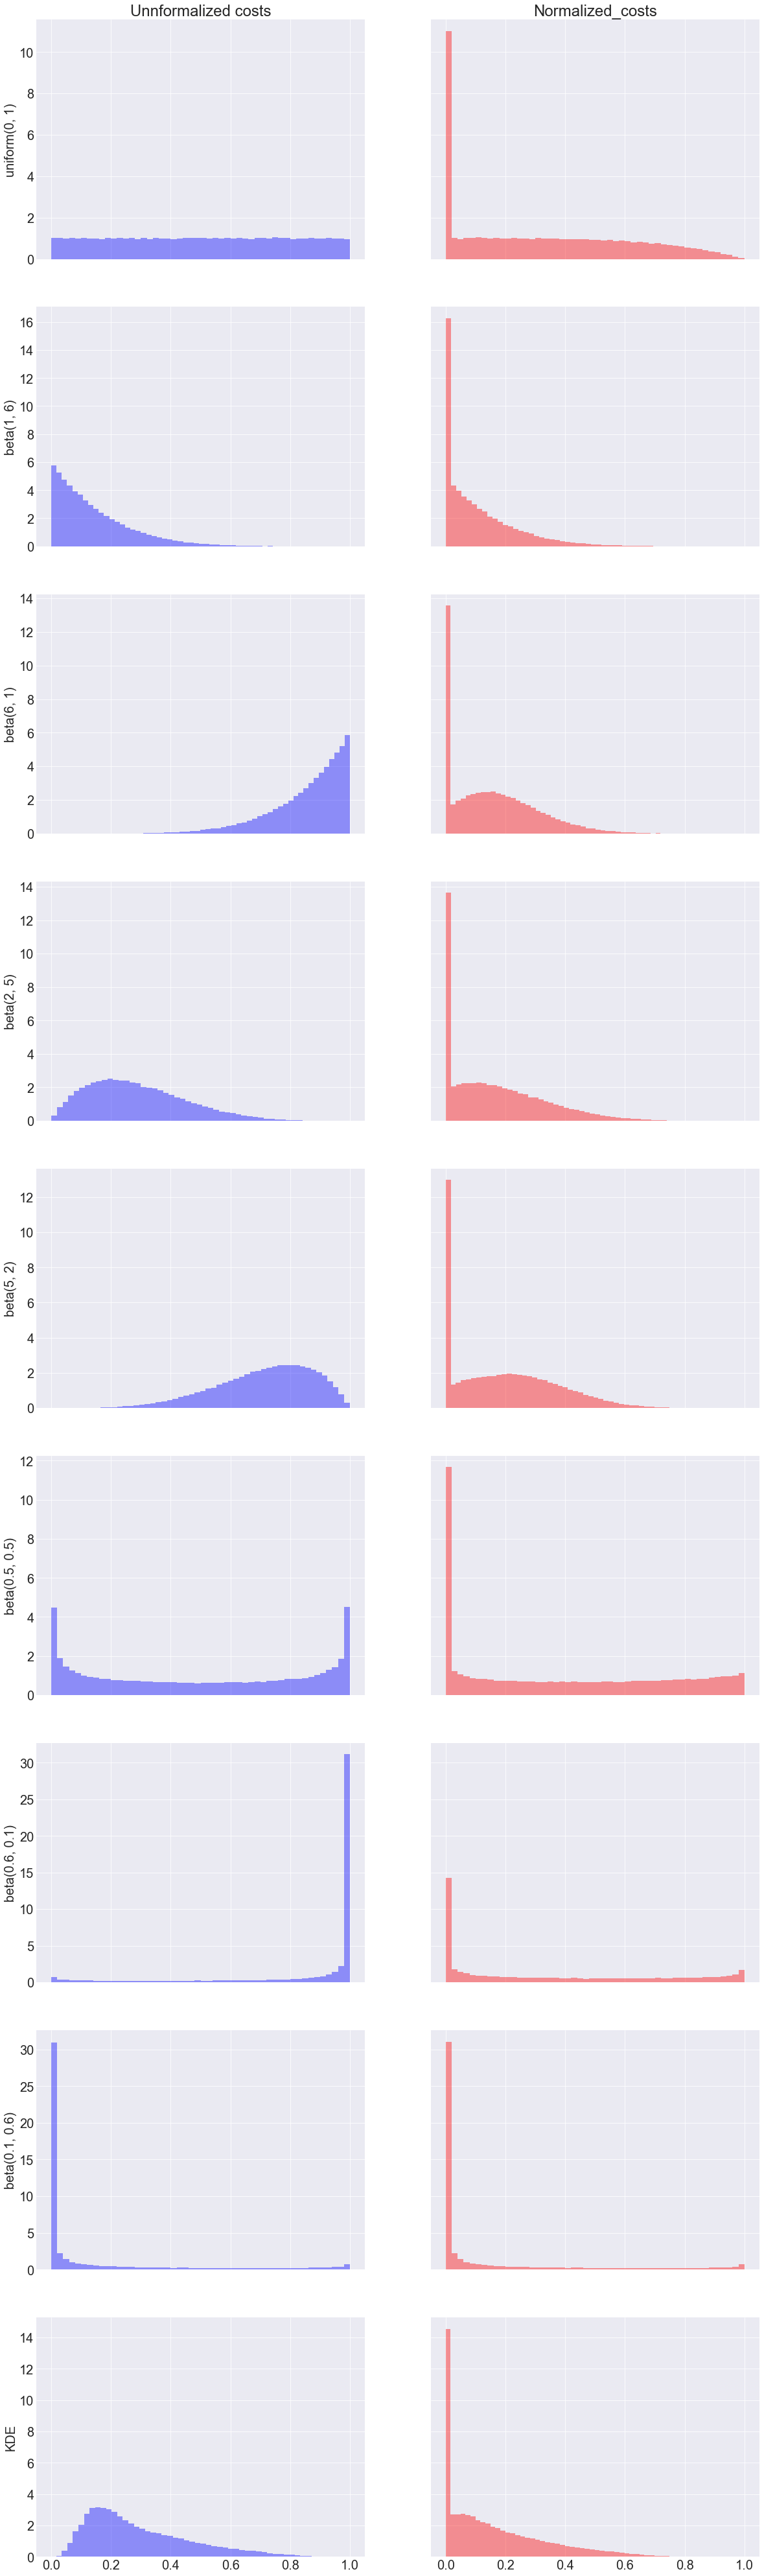

In [26]:
fig, ax = plt.subplots(len(labels), 2, figsize=(20, 8 * len(labels)), sharex=True, sharey='row')

for dist_id in range(len(labels)):
    ax[dist_id][0].hist(
        cost_pop[dist_id], bins=50, density=True, color='b', alpha=0.4
    )
    
    ax[dist_id][1].hist(
        increase_pop[dist_id], bins=50, density=True, color='r', alpha=0.4
    )
    
    ax[dist_id][0].set_ylabel(labels[dist_id])
    
ax[0][0].set_title('Unnformalized costs')
ax[0][1].set_title('Normalized_costs')

plt.show()